In [1]:
%matplotlib inline

In [2]:
import glob
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D,MaxPooling1D,\
GlobalAveragePooling1D, Flatten,Lambda ,Reshape ,Conv1DTranspose,Activation
from tensorflow.keras.losses import mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence

## Detection and classification of genetic mutations in BRCA1 gene in human chromosome 17
![dna](img/genetics-banner-x.png)
### Abstract
One of the major tasks in clinical genomics is the identification of mutations associated with human genetic diseases. Typically, genome-wide genetic studies identify a large number of variants that have potential association with a disease. However, to narrow this search and to pinpoint the variants that most likely cause a disease, a number of methods have been developed . These methods use the evolutionary conservation of nucleotide positions and/or the functional consequences of mutations to distinguish disease-associated variants from neutral and benign variants.

Breast cancer is a common disease. Each year, approximately 200,000 women in the United States are diagnosed with breast cancer, and one in nine American women will develop breast cancer in her lifetime. <br>
In 1994, the first gene associated with breast cancer - BRCA1 (for BReast CAncer1) was identified on chromosome 17.  When individuals carry a mutated form of BRCA1, they have an increased risk of developing breast or ovarian cancer at some point in their lives. Children of parents with a BRCA1 mutation have a 50 percent chance of inheriting the gene mutation.  

"The simplest denomination of breast cancer is based upon inherited susceptibility to breast cancer vs sporadic occurrences of breast cancer. Heightened breast cancer risk may be due to a genetic alteration that increases susceptibility based upon an inherited heterozygous gene defect in for example BRCA1, TP53, PTEN or other tumor suppressors"

The quote is taken from [DNA damage and breast cancer](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3168783/) written by Jennifer D Davis and Shiaw-Yih Lin.

### Overview
The current project is focused on applying deep learning approaches for detecting and classifying potential point mutations in patient's BRCA1 gene.Triple-negative breast cancers often contain inactivation of the DNA repair gene BRCA1. In fact, as much as 30% of breast cancers are thought to have some degree of BRCA1 inactivation.<br>
A key feature of the structure of a genes like BRCA1 is that their transcripts are typically subdivided into exon and intron regions. Exon regions are retained in the final mature mRNA molecule, while intron regions are cut out during post-transcriptional process. Indeed my focus was on exon's mutations.
![gene](img/gene.jpg)




#### Point mutations
Genetic mutations can be classified based on their effect on the protein structure:

- Missense: these mutations change the coded amino acid, hence they influence the final protein structure. Their effect can be uncertain or pathogenic.
- Nonsense: these mutations cause a shift in the reading frame or the formation of a premature stop codon (truncated protein). Very often these mutations are pathogenic.


But there's also another class of genetic mutations, rather infrequent, but possible:

- Start-loss: these mutations affect the initiation codon (the very first amino acid of the protein - a Methionine), and their effect on the final protein structure is very often pathogenic.
- Stop-loss: even rarer than start-loss, these mutations affect the last protein amino acid. Also for these mutations, the effect isn't easy to understand


![gene](img/mutations.png)

I want to try to clarify the strand issue. Consider the following stretch of double stranded DNA which encodes a short peptide:

![srands](img/dna_strands.png)

The actual biological transcription process works from the template strand of the DNA. This is the reason why the reference and the patient sequences are indeed taken from reverse strand  (aka Watson strand, strand −1).

### The Data
There is used various types of data:
- Reference and patient DNA of BRCA1 gene and exon's boundaries were taken from [National Library of Medicine](https://www.ncbi.nlm.nih.gov/genome/gdv/browser/genome/?id=GCF_000001405.39).

- All the DNA variants (mutation) were taken from [Health University of Utah](https://arup.utah.edu/database/BRCA/Variants/BRCA1.php)


#### Patient data
For the current research there is a patient DNA sequence with anomalies in exons: 2, 3, 4, 7, 13 and 14. Most of them are `non pathogenic`. Only one (in exon 2) is a pathogenic variant  c.1A>G - mutation type:start loss.

"Start-loss: these mutations affect the initiation codon, i.e. the very first amino acid of the protein (which is a Methionine), and their effect on the final protein structure (and therefore on the individual's clinical picture), is anything but easily deducible." The quote was taken from [Breda Genetics](https://bredagenetics.com/start-loss-mutations-in-rare-diseases/)

In [3]:
#Reading the patient DNA sequence
patient_data = pd.read_csv('dna_data/BRCA1_gene_sequence_patient.txt',header=None)

#Reading the reference DNA sequence
reference_data = pd.read_csv('dna_data/BRCA1_gene_sequence.txt', header=None)

#Reading the reference exon boundaries
exon_boundaries = pd.read_csv('dna_data/BRCA1_exon_bounderies.csv')

#Loading dna variants dataset
variants_data = pd.read_csv('dna_data/variants/dna_variants.csv')

### Implementation
After wide research I decided to use a convolutional autoencoder for anomaly detection in patient DNA. For the anomaly detection part I transformed the DNA sequences into arrays of numbers (1 - 5).Each one corresponding to each nucleotide and 5 is for letter 'N' (unknown)  .<br>
After many experiments I decided to use different approach for the classification part.
I transformed the DNA sequences into arrays of one hot encoded nucleotides.
The latter seemed more robust and reliable.<br>


Because of the relatively small size of described DNA variants (about 240), I had to find something different than regular classifier.
I decide to use a siamese network with contrastive loss function for classifying the anomalies.

In [4]:
def vectorize(seq):
    """
    Vectorize the the DNA sequence 
    """
    str_sequence = ''
    arr_sequence = []
    #Concatenate lines of strings
    for line in seq[0]:
         str_sequence += line
    #Populate the vector with the nucleotides
    for n in str_sequence:
        arr_sequence.append(n)
    return np.array(arr_sequence)

In [5]:
# Find the length of the longest exon
EXON_MAX_LENGTH = 0
for i in range(len(exon_boundaries)):
    start = exon_boundaries.loc[i].start
    end = exon_boundaries.loc[i].end
    diff = end - start + 1
    if diff > EXON_MAX_LENGTH:
        EXON_MAX_LENGTH = diff
    

In [6]:
#Vectorize the referent and patient data
ref_vec = vectorize(reference_data)
pat_vec = vectorize(patient_data)

In [7]:
def normalize(seq):
    """
    Normalize the sequence
    """
    return seq / np.max(seq)

In [8]:
def nucleotide_to_num(sequence):
    """
    Transforms DNA sequence to a sequence of numbers coresponding to certain nucleotide
    """
    ref_sequence_to_num = []
    nucleotide_to_num = {
        'A': 1.,
        'C': 2.,
        'G': 3.,
        'T': 4.,
        'N': 5.
    }
    for nucleodtide in sequence:
            ref_sequence_to_num.append(nucleotide_to_num[nucleodtide])

    return np.array(normalize(ref_sequence_to_num))

#### Exons boundaries
The exon boundaries were taken from [National Center for Biotechnology Information](https://www.ncbi.nlm.nih.gov/). They are basically the start and end position of the exon according the order of Human Genome version called ` Assembly GRCh38.p13 - Cr17`.<br>
For the current project only the exon sequences will be used.
The following function is extracting only exons and making their length even number. I needed this even lengths because of the nature of the autoencoder. 

In [9]:
def split_exons(seq):
    """Devide the DNA sequence on exons - remove the other parts"""
    exon_seq = []
    for i in range(len(exon_boundaries)):
        start = exon_boundaries.loc[i].start
        end = exon_boundaries.loc[i].end
        ex = seq[start : end]
        # Making the length of the exons to be even number
        if len(ex) % 2 != 0:
            ex = np.hstack((ex , ['N' for _ in range(1)]))
        exon_seq.append(nucleotide_to_num(ex))
    return exon_seq


In [10]:
#Extracting exons for the referent and patient sets
referent_exons = split_exons(ref_vec)
patient_exons = split_exons(pat_vec)

In [11]:
COPY_COUNT = 300
def create_dataset(X):
    """Create an 3D array with multiple copies of given sequence"""
    Xs=[]
    for i in range(COPY_COUNT):
        Xs.append(X)
    return np.array(Xs)

### Convolutional reconstruction autoencoder

The dataset for the anomaly detection part of the project is actually the entire DNA sequence of the BRCA1 gene. The idea is to train the model with the referent (healthy) DNA sequence.
After that the model should be able to detect potential changes in the patient DNA.
Since the input data is a 3d array i decided to use `convolutional reconstruction autoencoder model`
The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. In this case, sequence_length is 81070 (the length of  BRCA1 gene) and num_features is 4 (which corresponds to one hot encoded nucleotide).

An autoencoder is a special type of neural network that is trained to copy its input to its output.It will first encode the sequence  into a lower dimensional latent representation, then decodes the latent representation back to an sequence.<br>
The autoencoder was trained to minimize reconstruction error with the referent DNA (normal)  only, then I used it to reconstruct patient data. My hypothesis was that the mutated sequence will have higher reconstruction error.<br>
For the encoder part were used two `Conv1D` layers. For the "bottleneck" I used a `Flatten` layout. And for decoder part were used two `Conv1DTranspose` layers and one `Conv1D` with output size 1. The `Conv1DTranspose` purpose is to increase the volume size back to the original array spatial dimensions.

A special class `MutationDetector` was created to capsulate the `autoencoder`. This way it was easier to use it multiple times for each exon separately.


In [12]:
KRNL_SIZE = 7
latent_dim = 20
class MutationDetector(Model):
    """
    Capsulate an autoencoder in a class.
    This way it can be used multiple times as separate object.
    """
    def __init__(self, input_a):
        super(MutationDetector, self).__init__()
        
        #Encoder part ----------------------------------------------
        inputs = Input(shape=(input_a, 1))

        conv = Conv1D(
            filters=8, kernel_size=KRNL_SIZE, strides=2, padding="same", activation = 'relu')(inputs)
        

        conv = Conv1D(
            filters=4, kernel_size=KRNL_SIZE, strides=1, padding="same", activation="relu")(conv)

        """
        Storing the shape of the last convolutional layer
        to use it in the decoder part
        """
        vol_size = K.int_shape(conv)
        
        """
        Flatten the convolutional output to a 1d lattent space
        Pass it to a dense layer
        """
        flat = Flatten()(conv)
        latent = Dense(latent_dim)(flat)
        
        #Decoder part ----------------------------------------------

        dense = Dense(np.prod(vol_size[1:]))(latent)
        reshape = Reshape((vol_size[1], vol_size[2]))(dense)

        conv_trans = Conv1DTranspose(
            filters=4, kernel_size=KRNL_SIZE, strides=1, padding="same", activation = 'relu')(reshape)
        
        conv_trans = Conv1DTranspose(
            filters=8, kernel_size=KRNL_SIZE, strides=2,padding="same", activation = 'relu')(conv_trans)
        
        outputs = Conv1DTranspose(
            filters=1, kernel_size=KRNL_SIZE, padding="same", activation='sigmoid')(conv_trans)
        self.autoencoder = Model(inputs, outputs)
        
    def call(self, x):
        return self.autoencoder(x)
    
    def show_summary(self):
        #Returns the summary of the current object
        return self.autoencoder.summary()

In [13]:
def training_plot(hist,title):
    """
    Plot training and validation losses
    """
    fig, ax = plt.subplots(figsize=(6, 3), dpi=80)
    plt.plot(hist.history['loss'], label='Training loss')
    plt.plot(hist.history['val_loss'], label='Validation loss')
    ax.set_title(title)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    plt.legend()
    plt.show()

In [14]:
def calculate_threshold(predicted, referent):
    """
    Calculating train loss and threshold
    """
    train_loss = np.mean(np.abs(predicted - referent), axis=1) 
    threshold = np.max(train_loss)
    plt.hist(train_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()
    
    return threshold

The reference_set was used as both the input and the target since this is a reconstruction model.

#### Anomaly detection

In [15]:
anomalous_exon_names = []

def detect_anomalies(predicted, referent,threshold, exon_name):
    """
    Detect the samples which are anomalies.
    Calculate mean absolute error
    """
    test_loss = np.mean(np.abs(predicted - referent), axis=1)
    print('Anomaly detection - {}'.format(exon_name))
    
    # Finding the anomalies
    anomalies = test_loss > threshold
    anomaly_sum =  np.sum(anomalies)
    print("Count of anomalous nucleotides: ", anomaly_sum)
    
    #Print the anomaly nucleotide position 
    if anomaly_sum > 0:
        anomalous_exon_names.append(exon_name)
        print("Position of anomalous nucleotide: ", np.where(anomalies))
        print("Test losses {}".format(test_loss[np.where(anomalies)]))

Here , for every exon was created a train set ,a test set and an autoencoder. 
Every model was trained and it made it's predictions separately from the others.

===========Training for exon_01============
Epoch 1/30
15/15 - 10s - loss: 0.1775 - val_loss: 0.1708
Epoch 2/30
15/15 - 0s - loss: 0.1522 - val_loss: 0.1279
Epoch 3/30
15/15 - 0s - loss: 0.1098 - val_loss: 0.0902
Epoch 4/30
15/15 - 0s - loss: 0.0769 - val_loss: 0.0636
Epoch 5/30
15/15 - 0s - loss: 0.0527 - val_loss: 0.0417
Epoch 6/30
15/15 - 0s - loss: 0.0355 - val_loss: 0.0285
Epoch 7/30
15/15 - 0s - loss: 0.0245 - val_loss: 0.0199
Epoch 8/30
15/15 - 0s - loss: 0.0169 - val_loss: 0.0139
Epoch 9/30
15/15 - 0s - loss: 0.0124 - val_loss: 0.0102
Epoch 10/30
15/15 - 0s - loss: 0.0093 - val_loss: 0.0086
Epoch 11/30
15/15 - 0s - loss: 0.0074 - val_loss: 0.0064
Epoch 12/30
15/15 - 0s - loss: 0.0056 - val_loss: 0.0051
Epoch 13/30
15/15 - 0s - loss: 0.0048 - val_loss: 0.0046
Epoch 14/30
15/15 - 0s - loss: 0.0040 - val_loss: 0.0036
Epoch 15/30
15/15 - 0s - loss: 0.0034 - val_loss: 0.0036
Epoch 16/30
15/15 - 0s - loss: 0.0032 - val_loss: 0.0035
Epoch 17/30
15/15 - 0s - loss: 0.0034 - val_loss: 0.

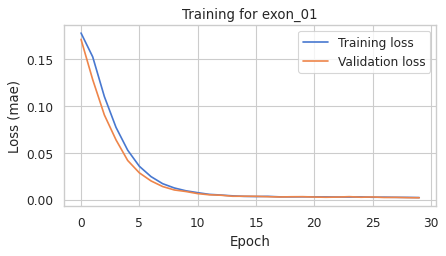

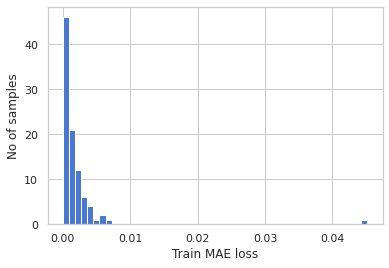

Reconstruction error threshold: 0.04515981674194336
Anomaly detection - exon_01
Count of anomalous nucleotides:  0
======== End of processing exon_01 ========  

===========Training for exon_02============
Epoch 1/30
15/15 - 9s - loss: 0.2848 - val_loss: 0.2796
Epoch 2/30
15/15 - 0s - loss: 0.2664 - val_loss: 0.2393
Epoch 3/30
15/15 - 0s - loss: 0.2000 - val_loss: 0.1674
Epoch 4/30
15/15 - 0s - loss: 0.1429 - val_loss: 0.1173
Epoch 5/30
15/15 - 0s - loss: 0.0989 - val_loss: 0.0827
Epoch 6/30
15/15 - 0s - loss: 0.0715 - val_loss: 0.0609
Epoch 7/30
15/15 - 0s - loss: 0.0537 - val_loss: 0.0476
Epoch 8/30
15/15 - 0s - loss: 0.0425 - val_loss: 0.0381
Epoch 9/30
15/15 - 0s - loss: 0.0353 - val_loss: 0.0329
Epoch 10/30
15/15 - 0s - loss: 0.0313 - val_loss: 0.0295
Epoch 11/30
15/15 - 0s - loss: 0.0280 - val_loss: 0.0271
Epoch 12/30
15/15 - 0s - loss: 0.0254 - val_loss: 0.0237
Epoch 13/30
15/15 - 0s - loss: 0.0227 - val_loss: 0.0213
Epoch 14/30
15/15 - 0s - loss: 0.0203 - val_loss: 0.0200
Epoch

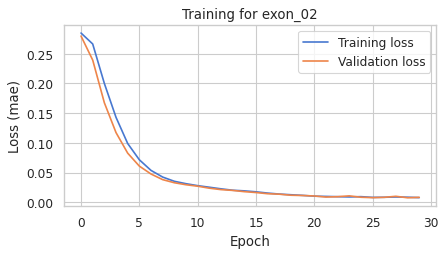

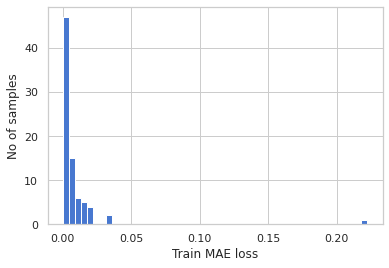

Reconstruction error threshold: 0.22216740436851978
Anomaly detection - exon_02
Count of anomalous nucleotides:  2
Position of anomalous nucleotide:  (array([ 0, 29]),)
Test losses [0.50054242 0.2221675 ]
======== End of processing exon_02 ========  

===========Training for exon_03============
Epoch 1/30
15/15 - 9s - loss: 0.2516 - val_loss: 0.2314
Epoch 2/30
15/15 - 0s - loss: 0.1931 - val_loss: 0.1367
Epoch 3/30
15/15 - 0s - loss: 0.1125 - val_loss: 0.0915
Epoch 4/30
15/15 - 0s - loss: 0.0764 - val_loss: 0.0642
Epoch 5/30
15/15 - 0s - loss: 0.0553 - val_loss: 0.0459
Epoch 6/30
15/15 - 0s - loss: 0.0414 - val_loss: 0.0369
Epoch 7/30
15/15 - 0s - loss: 0.0329 - val_loss: 0.0292
Epoch 8/30
15/15 - 0s - loss: 0.0258 - val_loss: 0.0231
Epoch 9/30
15/15 - 0s - loss: 0.0218 - val_loss: 0.0206
Epoch 10/30
15/15 - 0s - loss: 0.0196 - val_loss: 0.0187
Epoch 11/30
15/15 - 0s - loss: 0.0185 - val_loss: 0.0178
Epoch 12/30
15/15 - 0s - loss: 0.0180 - val_loss: 0.0175
Epoch 13/30
15/15 - 0s - loss

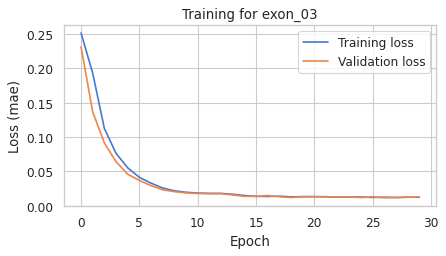

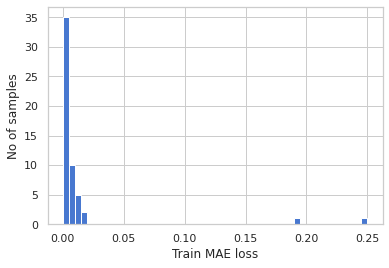

Reconstruction error threshold: 0.24999821186065674
Anomaly detection - exon_03
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([52]),)
Test losses [0.25322703]
======== End of processing exon_03 ========  

===========Training for exon_04============
Epoch 1/30
15/15 - 9s - loss: 0.2674 - val_loss: 0.2633
Epoch 2/30
15/15 - 0s - loss: 0.2522 - val_loss: 0.2288
Epoch 3/30
15/15 - 0s - loss: 0.1970 - val_loss: 0.1562
Epoch 4/30
15/15 - 0s - loss: 0.1275 - val_loss: 0.0999
Epoch 5/30
15/15 - 0s - loss: 0.0815 - val_loss: 0.0647
Epoch 6/30
15/15 - 0s - loss: 0.0551 - val_loss: 0.0442
Epoch 7/30
15/15 - 0s - loss: 0.0386 - val_loss: 0.0323
Epoch 8/30
15/15 - 0s - loss: 0.0314 - val_loss: 0.0295
Epoch 9/30
15/15 - 0s - loss: 0.0294 - val_loss: 0.0284
Epoch 10/30
15/15 - 0s - loss: 0.0279 - val_loss: 0.0270
Epoch 11/30
15/15 - 0s - loss: 0.0258 - val_loss: 0.0244
Epoch 12/30
15/15 - 0s - loss: 0.0247 - val_loss: 0.0252
Epoch 13/30
15/15 - 0s - loss: 0.0247 - val_

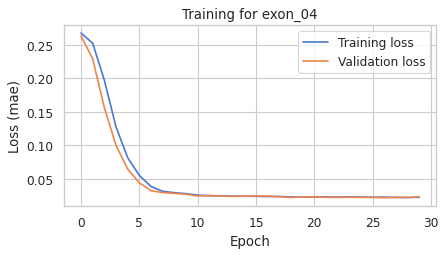

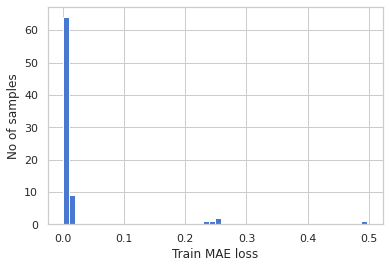

Reconstruction error threshold: 0.49754321575164795
Anomaly detection - exon_04
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([19]),)
Test losses [0.7474227]
======== End of processing exon_04 ========  

===========Training for exon_05============
Epoch 1/30
15/15 - 9s - loss: 0.2226 - val_loss: 0.2150
Epoch 2/30
15/15 - 0s - loss: 0.2029 - val_loss: 0.1898
Epoch 3/30
15/15 - 0s - loss: 0.1750 - val_loss: 0.1535
Epoch 4/30
15/15 - 0s - loss: 0.1325 - val_loss: 0.1081
Epoch 5/30
15/15 - 0s - loss: 0.0892 - val_loss: 0.0722
Epoch 6/30
15/15 - 0s - loss: 0.0610 - val_loss: 0.0504
Epoch 7/30
15/15 - 0s - loss: 0.0429 - val_loss: 0.0365
Epoch 8/30
15/15 - 0s - loss: 0.0328 - val_loss: 0.0283
Epoch 9/30
15/15 - 0s - loss: 0.0250 - val_loss: 0.0219
Epoch 10/30
15/15 - 0s - loss: 0.0197 - val_loss: 0.0176
Epoch 11/30
15/15 - 0s - loss: 0.0164 - val_loss: 0.0150
Epoch 12/30
15/15 - 0s - loss: 0.0147 - val_loss: 0.0137
Epoch 13/30
15/15 - 0s - loss: 0.0132 - val_l

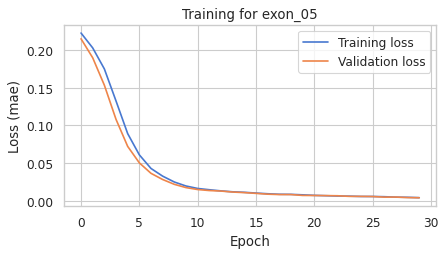

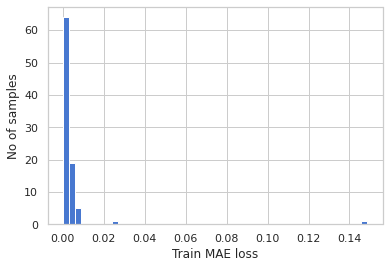

Reconstruction error threshold: 0.14869280457496642
Anomaly detection - exon_05
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([11]),)
Test losses [0.14869289]
======== End of processing exon_05 ========  

===========Training for exon_06============
Epoch 1/30
15/15 - 9s - loss: 0.2507 - val_loss: 0.2386
Epoch 2/30
15/15 - 0s - loss: 0.2051 - val_loss: 0.1713
Epoch 3/30
15/15 - 0s - loss: 0.1435 - val_loss: 0.1107
Epoch 4/30
15/15 - 0s - loss: 0.0916 - val_loss: 0.0762
Epoch 5/30
15/15 - 0s - loss: 0.0680 - val_loss: 0.0598
Epoch 6/30
15/15 - 0s - loss: 0.0522 - val_loss: 0.0441
Epoch 7/30
15/15 - 0s - loss: 0.0389 - val_loss: 0.0336
Epoch 8/30
15/15 - 0s - loss: 0.0303 - val_loss: 0.0264
Epoch 9/30
15/15 - 0s - loss: 0.0244 - val_loss: 0.0222
Epoch 10/30
15/15 - 0s - loss: 0.0202 - val_loss: 0.0184
Epoch 11/30
15/15 - 0s - loss: 0.0173 - val_loss: 0.0169
Epoch 12/30
15/15 - 0s - loss: 0.0166 - val_loss: 0.0159
Epoch 13/30
15/15 - 0s - loss: 0.0158 - val_

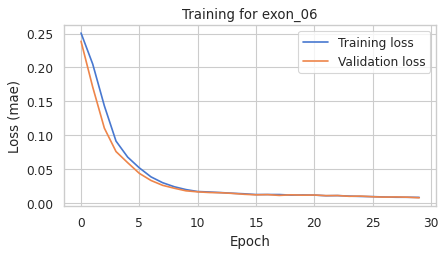

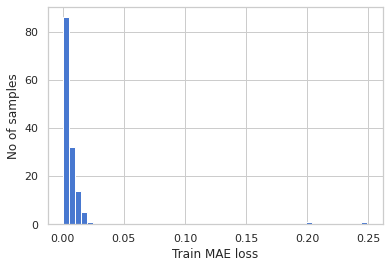

Reconstruction error threshold: 0.2492716908454895
Anomaly detection - exon_06
Count of anomalous nucleotides:  0
======== End of processing exon_06 ========  

===========Training for exon_07============
Epoch 1/30
15/15 - 9s - loss: 0.2425 - val_loss: 0.2410
Epoch 2/30
15/15 - 0s - loss: 0.2361 - val_loss: 0.2240
Epoch 3/30
15/15 - 0s - loss: 0.1903 - val_loss: 0.1547
Epoch 4/30
15/15 - 0s - loss: 0.1264 - val_loss: 0.0936
Epoch 5/30
15/15 - 0s - loss: 0.0757 - val_loss: 0.0582
Epoch 6/30
15/15 - 0s - loss: 0.0500 - val_loss: 0.0422
Epoch 7/30
15/15 - 0s - loss: 0.0368 - val_loss: 0.0319
Epoch 8/30
15/15 - 0s - loss: 0.0289 - val_loss: 0.0251
Epoch 9/30
15/15 - 0s - loss: 0.0244 - val_loss: 0.0235
Epoch 10/30
15/15 - 0s - loss: 0.0224 - val_loss: 0.0207
Epoch 11/30
15/15 - 0s - loss: 0.0203 - val_loss: 0.0186
Epoch 12/30
15/15 - 0s - loss: 0.0185 - val_loss: 0.0180
Epoch 13/30
15/15 - 0s - loss: 0.0177 - val_loss: 0.0170
Epoch 14/30
15/15 - 0s - loss: 0.0167 - val_loss: 0.0158
Epoch 

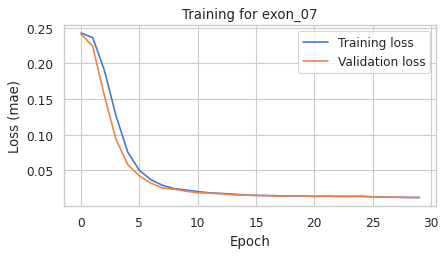

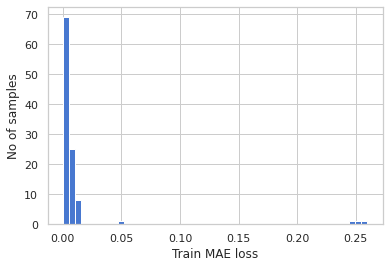

Reconstruction error threshold: 0.2598261833190918
Anomaly detection - exon_07
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([27]),)
Test losses [0.49831474]
======== End of processing exon_07 ========  

===========Training for exon_08============
Epoch 1/30
15/15 - 1s - loss: 0.2123 - val_loss: 0.1960
Epoch 2/30
15/15 - 0s - loss: 0.1748 - val_loss: 0.1547
Epoch 3/30
15/15 - 0s - loss: 0.1363 - val_loss: 0.1176
Epoch 4/30
15/15 - 0s - loss: 0.1035 - val_loss: 0.0877
Epoch 5/30
15/15 - 0s - loss: 0.0748 - val_loss: 0.0609
Epoch 6/30
15/15 - 0s - loss: 0.0515 - val_loss: 0.0412
Epoch 7/30
15/15 - 0s - loss: 0.0350 - val_loss: 0.0296
Epoch 8/30
15/15 - 0s - loss: 0.0256 - val_loss: 0.0222
Epoch 9/30
15/15 - 0s - loss: 0.0194 - val_loss: 0.0173
Epoch 10/30
15/15 - 0s - loss: 0.0153 - val_loss: 0.0142
Epoch 11/30
15/15 - 0s - loss: 0.0134 - val_loss: 0.0123
Epoch 12/30
15/15 - 0s - loss: 0.0117 - val_loss: 0.0114
Epoch 13/30
15/15 - 0s - loss: 0.0110 - val_l

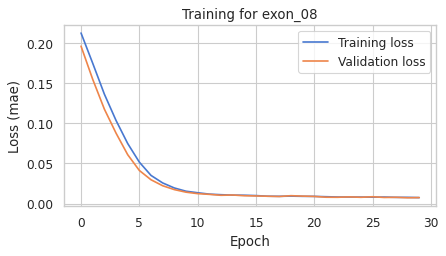

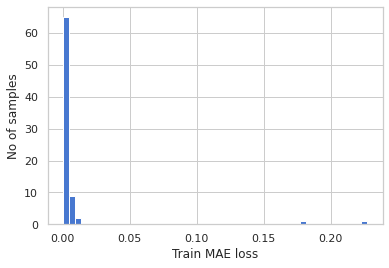

Reconstruction error threshold: 0.22729121446609502
Anomaly detection - exon_08
Count of anomalous nucleotides:  0
======== End of processing exon_08 ========  

===========Training for exon_09============
Epoch 1/30
15/15 - 1s - loss: 0.1920 - val_loss: 0.1722
Epoch 2/30
15/15 - 0s - loss: 0.1528 - val_loss: 0.1278
Epoch 3/30
15/15 - 0s - loss: 0.1076 - val_loss: 0.0861
Epoch 4/30
15/15 - 0s - loss: 0.0726 - val_loss: 0.0591
Epoch 5/30
15/15 - 0s - loss: 0.0493 - val_loss: 0.0397
Epoch 6/30
15/15 - 0s - loss: 0.0345 - val_loss: 0.0289
Epoch 7/30
15/15 - 0s - loss: 0.0252 - val_loss: 0.0219
Epoch 8/30
15/15 - 0s - loss: 0.0195 - val_loss: 0.0178
Epoch 9/30
15/15 - 0s - loss: 0.0170 - val_loss: 0.0160
Epoch 10/30
15/15 - 0s - loss: 0.0155 - val_loss: 0.0147
Epoch 11/30
15/15 - 0s - loss: 0.0141 - val_loss: 0.0134
Epoch 12/30
15/15 - 0s - loss: 0.0130 - val_loss: 0.0121
Epoch 13/30
15/15 - 0s - loss: 0.0116 - val_loss: 0.0115
Epoch 14/30
15/15 - 0s - loss: 0.0107 - val_loss: 0.0100
Epoch

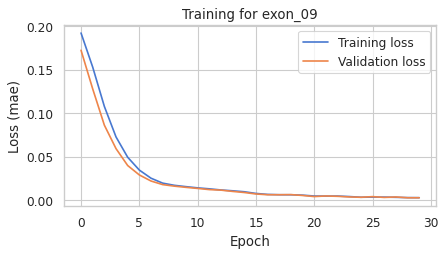

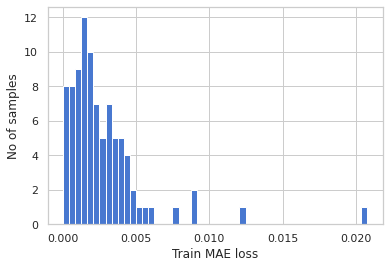

Reconstruction error threshold: 0.02076256275177002
Anomaly detection - exon_09
Count of anomalous nucleotides:  0
======== End of processing exon_09 ========  

===========Training for exon_10============
Epoch 1/30
15/15 - 9s - loss: 0.2315 - val_loss: 0.2285
Epoch 2/30
15/15 - 0s - loss: 0.2149 - val_loss: 0.1841
Epoch 3/30
15/15 - 0s - loss: 0.1549 - val_loss: 0.1310
Epoch 4/30
15/15 - 0s - loss: 0.1145 - val_loss: 0.0976
Epoch 5/30
15/15 - 0s - loss: 0.0853 - val_loss: 0.0727
Epoch 6/30
15/15 - 0s - loss: 0.0639 - val_loss: 0.0563
Epoch 7/30
15/15 - 0s - loss: 0.0510 - val_loss: 0.0459
Epoch 8/30
15/15 - 0s - loss: 0.0422 - val_loss: 0.0387
Epoch 9/30
15/15 - 0s - loss: 0.0361 - val_loss: 0.0332
Epoch 10/30
15/15 - 0s - loss: 0.0316 - val_loss: 0.0291
Epoch 11/30
15/15 - 0s - loss: 0.0281 - val_loss: 0.0271
Epoch 12/30
15/15 - 0s - loss: 0.0257 - val_loss: 0.0252
Epoch 13/30
15/15 - 0s - loss: 0.0242 - val_loss: 0.0234
Epoch 14/30
15/15 - 0s - loss: 0.0225 - val_loss: 0.0222
Epoch

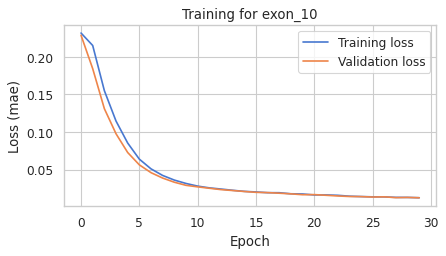

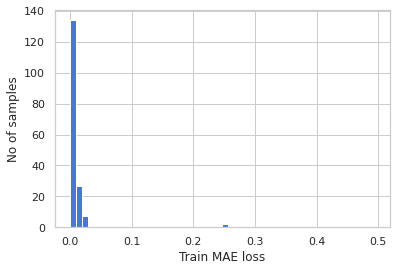

Reconstruction error threshold: 0.4937223792076111
Anomaly detection - exon_10
Count of anomalous nucleotides:  0
======== End of processing exon_10 ========  

===========Training for exon_11============
Epoch 1/30
15/15 - 9s - loss: 0.2187 - val_loss: 0.2110
Epoch 2/30
15/15 - 0s - loss: 0.1881 - val_loss: 0.1550
Epoch 3/30
15/15 - 0s - loss: 0.1337 - val_loss: 0.1102
Epoch 4/30
15/15 - 0s - loss: 0.0941 - val_loss: 0.0794
Epoch 5/30
15/15 - 0s - loss: 0.0723 - val_loss: 0.0650
Epoch 6/30
15/15 - 0s - loss: 0.0602 - val_loss: 0.0556
Epoch 7/30
15/15 - 0s - loss: 0.0516 - val_loss: 0.0474
Epoch 8/30
15/15 - 0s - loss: 0.0439 - val_loss: 0.0402
Epoch 9/30
15/15 - 0s - loss: 0.0368 - val_loss: 0.0332
Epoch 10/30
15/15 - 0s - loss: 0.0309 - val_loss: 0.0285
Epoch 11/30
15/15 - 0s - loss: 0.0269 - val_loss: 0.0253
Epoch 12/30
15/15 - 0s - loss: 0.0240 - val_loss: 0.0223
Epoch 13/30
15/15 - 0s - loss: 0.0213 - val_loss: 0.0201
Epoch 14/30
15/15 - 0s - loss: 0.0193 - val_loss: 0.0182
Epoch 

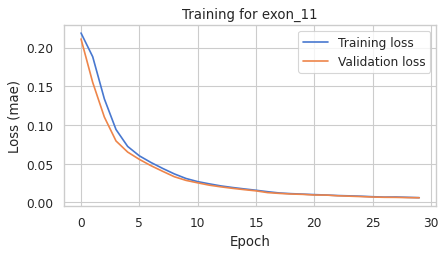

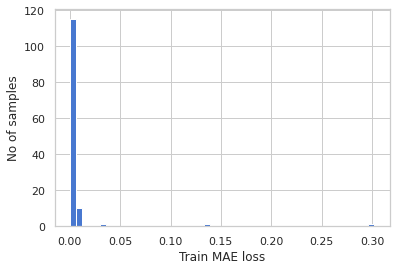

Reconstruction error threshold: 0.30231815576553345
Anomaly detection - exon_11
Count of anomalous nucleotides:  0
======== End of processing exon_11 ========  

===========Training for exon_12============
Epoch 1/30
15/15 - 9s - loss: 0.2039 - val_loss: 0.1911
Epoch 2/30
15/15 - 0s - loss: 0.1723 - val_loss: 0.1490
Epoch 3/30
15/15 - 0s - loss: 0.1274 - val_loss: 0.1078
Epoch 4/30
15/15 - 0s - loss: 0.0957 - val_loss: 0.0834
Epoch 5/30
15/15 - 0s - loss: 0.0744 - val_loss: 0.0659
Epoch 6/30
15/15 - 0s - loss: 0.0595 - val_loss: 0.0526
Epoch 7/30
15/15 - 0s - loss: 0.0488 - val_loss: 0.0452
Epoch 8/30
15/15 - 0s - loss: 0.0417 - val_loss: 0.0387
Epoch 9/30
15/15 - 0s - loss: 0.0364 - val_loss: 0.0338
Epoch 10/30
15/15 - 0s - loss: 0.0319 - val_loss: 0.0292
Epoch 11/30
15/15 - 0s - loss: 0.0276 - val_loss: 0.0259
Epoch 12/30
15/15 - 0s - loss: 0.0242 - val_loss: 0.0229
Epoch 13/30
15/15 - 0s - loss: 0.0218 - val_loss: 0.0210
Epoch 14/30
15/15 - 0s - loss: 0.0201 - val_loss: 0.0192
Epoch

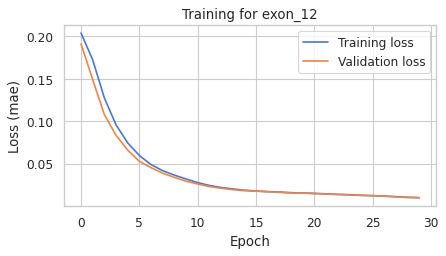

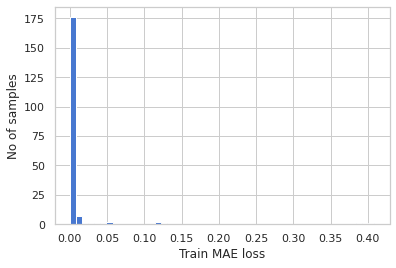

Reconstruction error threshold: 0.40868947505950926
Anomaly detection - exon_12
Count of anomalous nucleotides:  0
======== End of processing exon_12 ========  

===========Training for exon_13============
Epoch 1/30
15/15 - 9s - loss: 0.1986 - val_loss: 0.1821
Epoch 2/30
15/15 - 0s - loss: 0.1606 - val_loss: 0.1378
Epoch 3/30
15/15 - 0s - loss: 0.1249 - val_loss: 0.1099
Epoch 4/30
15/15 - 0s - loss: 0.0991 - val_loss: 0.0865
Epoch 5/30
15/15 - 0s - loss: 0.0773 - val_loss: 0.0685
Epoch 6/30
15/15 - 0s - loss: 0.0632 - val_loss: 0.0570
Epoch 7/30
15/15 - 0s - loss: 0.0532 - val_loss: 0.0490
Epoch 8/30
15/15 - 0s - loss: 0.0461 - val_loss: 0.0437
Epoch 9/30
15/15 - 0s - loss: 0.0415 - val_loss: 0.0393
Epoch 10/30
15/15 - 0s - loss: 0.0377 - val_loss: 0.0359
Epoch 11/30
15/15 - 0s - loss: 0.0347 - val_loss: 0.0333
Epoch 12/30
15/15 - 0s - loss: 0.0322 - val_loss: 0.0310
Epoch 13/30
15/15 - 0s - loss: 0.0301 - val_loss: 0.0290
Epoch 14/30
15/15 - 0s - loss: 0.0280 - val_loss: 0.0272
Epoch

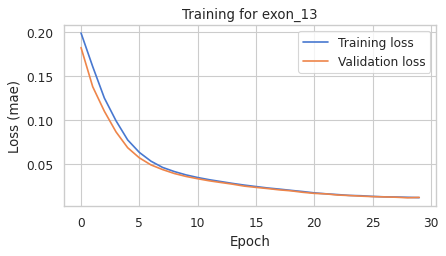

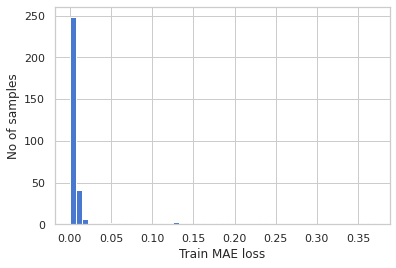

Reconstruction error threshold: 0.36978744268417363
Anomaly detection - exon_13
Count of anomalous nucleotides:  2
Position of anomalous nucleotide:  (array([125, 289]),)
Test losses [0.74480762 0.36979764]
======== End of processing exon_13 ========  

===========Training for exon_14============
Epoch 1/30
15/15 - 9s - loss: 0.2684 - val_loss: 0.2643
Epoch 2/30
15/15 - 0s - loss: 0.2492 - val_loss: 0.2160
Epoch 3/30
15/15 - 0s - loss: 0.1785 - val_loss: 0.1413
Epoch 4/30
15/15 - 0s - loss: 0.1115 - val_loss: 0.0817
Epoch 5/30
15/15 - 0s - loss: 0.0644 - val_loss: 0.0478
Epoch 6/30
15/15 - 0s - loss: 0.0420 - val_loss: 0.0354
Epoch 7/30
15/15 - 0s - loss: 0.0336 - val_loss: 0.0304
Epoch 8/30
15/15 - 0s - loss: 0.0284 - val_loss: 0.0266
Epoch 9/30
15/15 - 0s - loss: 0.0250 - val_loss: 0.0227
Epoch 10/30
15/15 - 0s - loss: 0.0196 - val_loss: 0.0158
Epoch 11/30
15/15 - 0s - loss: 0.0148 - val_loss: 0.0130
Epoch 12/30
15/15 - 0s - loss: 0.0123 - val_loss: 0.0115
Epoch 13/30
15/15 - 0s - lo

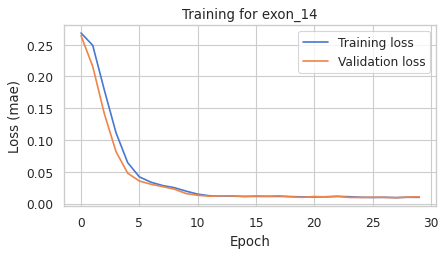

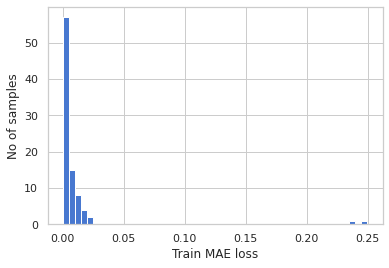

Reconstruction error threshold: 0.2496626377105713
Anomaly detection - exon_14
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([4]),)
Test losses [0.49999022]
======== End of processing exon_14 ========  

===========Training for exon_15============
Epoch 1/30
15/15 - 1s - loss: 0.3057 - val_loss: 0.3020
Epoch 2/30
15/15 - 0s - loss: 0.2921 - val_loss: 0.2713
Epoch 3/30
15/15 - 0s - loss: 0.2274 - val_loss: 0.1903
Epoch 4/30
15/15 - 0s - loss: 0.1699 - val_loss: 0.1465
Epoch 5/30
15/15 - 0s - loss: 0.1272 - val_loss: 0.1064
Epoch 6/30
15/15 - 0s - loss: 0.0919 - val_loss: 0.0778
Epoch 7/30
15/15 - 0s - loss: 0.0695 - val_loss: 0.0631
Epoch 8/30
15/15 - 0s - loss: 0.0596 - val_loss: 0.0560
Epoch 9/30
15/15 - 0s - loss: 0.0533 - val_loss: 0.0500
Epoch 10/30
15/15 - 0s - loss: 0.0484 - val_loss: 0.0463
Epoch 11/30
15/15 - 0s - loss: 0.0447 - val_loss: 0.0433
Epoch 12/30
15/15 - 0s - loss: 0.0433 - val_loss: 0.0419
Epoch 13/30
15/15 - 0s - loss: 0.0416 - val_lo

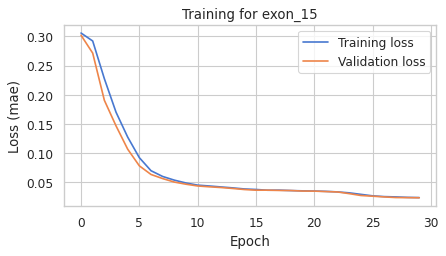

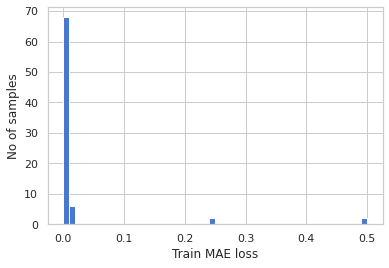

Reconstruction error threshold: 0.49994945526123047
Anomaly detection - exon_15
Count of anomalous nucleotides:  0
======== End of processing exon_15 ========  

===========Training for exon_16============
Epoch 1/30
15/15 - 9s - loss: 0.2150 - val_loss: 0.1952
Epoch 2/30
15/15 - 0s - loss: 0.1653 - val_loss: 0.1331
Epoch 3/30
15/15 - 0s - loss: 0.1100 - val_loss: 0.0876
Epoch 4/30
15/15 - 0s - loss: 0.0769 - val_loss: 0.0664
Epoch 5/30
15/15 - 0s - loss: 0.0554 - val_loss: 0.0445
Epoch 6/30
15/15 - 0s - loss: 0.0353 - val_loss: 0.0275
Epoch 7/30
15/15 - 0s - loss: 0.0242 - val_loss: 0.0205
Epoch 8/30
15/15 - 0s - loss: 0.0186 - val_loss: 0.0163
Epoch 9/30
15/15 - 0s - loss: 0.0151 - val_loss: 0.0135
Epoch 10/30
15/15 - 0s - loss: 0.0125 - val_loss: 0.0109
Epoch 11/30
15/15 - 0s - loss: 0.0107 - val_loss: 0.0100
Epoch 12/30
15/15 - 0s - loss: 0.0095 - val_loss: 0.0084
Epoch 13/30
15/15 - 0s - loss: 0.0083 - val_loss: 0.0079
Epoch 14/30
15/15 - 0s - loss: 0.0074 - val_loss: 0.0066
Epoch

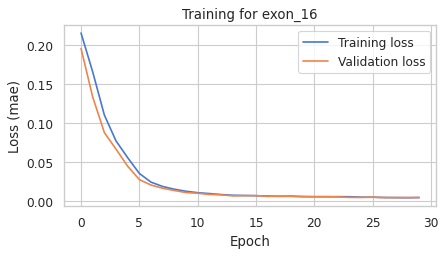

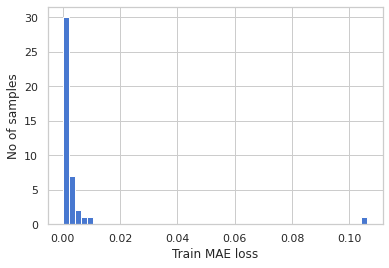

Reconstruction error threshold: 0.10628277063369751
Anomaly detection - exon_16
Count of anomalous nucleotides:  0
======== End of processing exon_16 ========  

===========Training for exon_17============
Epoch 1/30
15/15 - 9s - loss: 0.2397 - val_loss: 0.2367
Epoch 2/30
15/15 - 0s - loss: 0.2259 - val_loss: 0.2013
Epoch 3/30
15/15 - 0s - loss: 0.1705 - val_loss: 0.1448
Epoch 4/30
15/15 - 0s - loss: 0.1297 - val_loss: 0.1160
Epoch 5/30
15/15 - 0s - loss: 0.1047 - val_loss: 0.0922
Epoch 6/30
15/15 - 0s - loss: 0.0812 - val_loss: 0.0706
Epoch 7/30
15/15 - 0s - loss: 0.0627 - val_loss: 0.0546
Epoch 8/30
15/15 - 0s - loss: 0.0500 - val_loss: 0.0453
Epoch 9/30
15/15 - 0s - loss: 0.0415 - val_loss: 0.0383
Epoch 10/30
15/15 - 0s - loss: 0.0354 - val_loss: 0.0327
Epoch 11/30
15/15 - 0s - loss: 0.0311 - val_loss: 0.0298
Epoch 12/30
15/15 - 0s - loss: 0.0287 - val_loss: 0.0277
Epoch 13/30
15/15 - 0s - loss: 0.0264 - val_loss: 0.0256
Epoch 14/30
15/15 - 0s - loss: 0.0246 - val_loss: 0.0233
Epoch

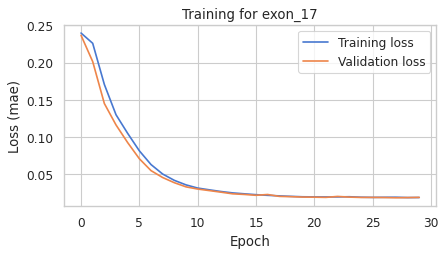

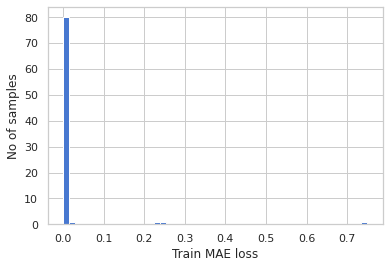

Reconstruction error threshold: 0.7493552491650917
Anomaly detection - exon_17
Count of anomalous nucleotides:  0
======== End of processing exon_17 ========  



In [16]:

for exon_n in range(len(referent_exons)):
    
    #Creating the exon names
    exon_name = 'exon_0' + str(exon_n+1) if exon_n+1 < 10 else 'exon_' + str(exon_n+1)
    
    #Converting the sequences into required shape
    reference_set = create_dataset(referent_exons[exon_n])
    reference_set = reference_set.reshape(COPY_COUNT, len(referent_exons[exon_n]), 1)
    
    #Calling the autoencoder
    autoencoder = MutationDetector(reference_set.shape[1])
    
    #Compile the model using optimizer adam and loss: mean absolute error
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mae")

    tr_title = 'Training for {}'.format(exon_name)
    print( '==========='+ tr_title +'============')
    
    #Fitting the model
    history = autoencoder.fit(reference_set, reference_set,
        epochs=30,
        batch_size=16,
        validation_split=0.2,
        verbose=2)
    
    print(autoencoder.show_summary())

    #Plot training result
    training_plot(history, tr_title) 
    
    """
    Predict the referent data to calculate the training loss
    it is needed to determine the reconstruction loss
    """
    predict = autoencoder.predict(reference_set)

    # Get reconstruction loss threshold.
    threshold = calculate_threshold(predict[0], reference_set[0])
    print("Reconstruction error threshold:", threshold)
    
    # Loading patient exon sequence
    patient_set = patient_exons[exon_n].reshape(1,  len(referent_exons[exon_n]), 1)
    test_predict = autoencoder.predict(patient_set)
    
    #Searching for anomalies
    detect_anomalies(test_predict[0] , patient_set[0], threshold, exon_name)
    
    print("======== End of processing {} ========  \n".format(exon_name))


In [17]:
"Mutations of BRCA1 gene were found in: {}".format(anomalous_exon_names)

"Mutations of BRCA1 gene were found in: ['exon_02', 'exon_03', 'exon_04', 'exon_05', 'exon_07', 'exon_13', 'exon_14']"

All the anomalous exons were found by the autoencoder. The problem is that there is one additional - exon_5. It is not in the list of known anomalous exons of the patient DNA.<br>
The exons of interest were found and now i had to classify them.

### Classifying the the anomalous sequences
<br>

### Siamese network


During my research I realized that there aren't so much DNA variants for different exons in BRCA1 gene. The overall count of the variants is 241.<br>
So I came to the conclusion that I need something different than common classifier to determine which anomalous sequence belongs to which class (pathogenic , not pathogenic) , mutation type or nucleotide change.<br>
Then I decide to try `siamese network` with `contrastive loss function`.

Practical, real-world use cases of `siamese networks` include face recognition, signature verification, prescription pill identification, and many more!

Furthermore, `siamese networks` can be trained with very little data, which actually I was aiming for.<br>
The concept of a `siamese network`:
    ![siamese](img/s_network.jpeg)<br>
Two convolutional network to be merged and to output the similarity of two entries in a pair.

#### DNA Variants

The DNA variants were taken from BRCA1 database of [Health University of Utah](https://arup.utah.edu/database/BRCA/Variants/BRCA1.php). The data includes all the recorded mutations classified as `Definitely pathogenic` , `likely not pathogenic` and `not pathogenic`.All the nucleotide changes have mutation type:  `Start loss`,`Splice site`, `Missense` or `Nonsence`

In [18]:
variants_data.head()

,variant,location,nucleotide change,mutation type,classification
0,GTGGATTTATCTGCTCTTCGCGTTGAAGAAGTACAAAATGTCATTA...,exon_02,c.1A>G,start loss,pathogenic
1,ACGGATTTATCTGCTCTTCGCGTTGAAGAAGTACAAAATGTCATTA...,exon_02,c.2T>C,start loss,pathogenic
2,AGGGATTTATCTGCTCTTCGCGTTGAAGAAGTACAAAATGTCATTA...,exon_02,c.2T>G,start loss,pathogenic
3,ATCGATTTATCTGCTCTTCGCGTTGAAGAAGTACAAAATGTCATTA...,exon_02,c.3G>C,start loss,pathogenic
4,ATTGATTTATCTGCTCTTCGCGTTGAAGAAGTACAAAATGTCATTA...,exon_02,c.3G>T,start loss,pathogenic


Only the variants of the anomalous exons were taken for the classification.
Next steps were to vectorize the DNA sequences of the variants.<br>Because the network requires to the sequences to be with equal lengths, the shorter sequences were made as long as the longest sequence by adding sufficient count of 'N's at their ends.

#### Missing information for variants
Unfortunately, during my research I couldn't find any variants for exons: 1, 8 and 10.
So this is the reason why I didn't considered them for the classification.

In [19]:
# Vectorize the patient BRCA1 gene sequence
vec_patient_sequence = vectorize(patient_data)
patient_exons = {}
exon_boundaries_df = exon_boundaries.set_index('name')
missing_data = ['exon_01','exon_08','exon_10']
# Create dictionary with detetected by the autencoder anomalies
for name in anomalous_exon_names:
    if name in missing_data:
        continue
    address = exon_boundaries_df.loc[name]
    patient_exons[name] = vec_patient_sequence[address.start : address.end]

In [20]:
def nucleotide_to_vector(sequence):
    """
    Transforms DNA sequence to a array of one-hot encoded nucleotides
    """
    ref_sequence_to_vec = []
    nucleotide_to_vec = {
        'A': [1., 0., 0., 0.],
        'C': [0., 1., 0., 0.],
        'G': [0. ,0. ,1., 0.],
        'T': [0., 0., 0., 1.],
        'N': [0., 0., 0., 0.]
    }
    for nucleodtide in sequence:
            ref_sequence_to_vec.append(nucleotide_to_vec[nucleodtide])

    return np.array(ref_sequence_to_vec)

Creating the variants data frame with vectorized sequences, so that all the variants have the same length. The shorter sequences received subsequence with letter 'N' at the end.

In [21]:
EXON_MAX_LENGTH = len(max(variants_data.variant, key=len))
vec_variants_dict = {'variant':[],'location':[],'classification':[],'nucleotide change':[],
                     'mutation type':[]}
for i in range(len(variants_data)):
    row = variants_data.loc[i]
    sequence = row.variant
    # Make the exons as long as the longest one
    sequence = sequence + 'N'* (EXON_MAX_LENGTH-len(sequence))
    #Transform the nucleotides sequence to one hot vector
    sequence = nucleotide_to_vector(sequence)
    
    #Populate the variant dictionary
    vec_variants_dict['variant'].append(sequence)
    vec_variants_dict['location'].append(row.location.strip())
    vec_variants_dict['classification'].append(row.classification.strip()) 
    vec_variants_dict['nucleotide change'].append(row[' nucleotide change'].strip()) 
    vec_variants_dict['mutation type'].append(row['mutation type']) 
    
#Populate a dataframe with required data
vec_variants_df = pd.DataFrame(vec_variants_dict).sample(frac=1)    
vec_variants_df = vec_variants_df.reset_index()
vec_variants_df = vec_variants_df.drop(columns=['index'])


In [22]:
vec_variants_df.head()

,variant,location,classification,nucleotide change,mutation type
0,"[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",exon_15,non pathogenic,c.4840C>T,misssense
1,"[[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",exon_12,pathogenic,c.4349C>A,nonsense
2,"[[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",exon_12,non pathogenic,c.4288C>T,misssense
3,"[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",exon_15,non pathogenic,c.4910C>T,misssense
4,"[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",exon_15,non pathogenic,c.4776C>A,misssense


In [23]:
"""
Create and populate a dictionary with data, so that after the predictions,
the data of predicted variant should be acessible
"""
pairs_dict={'current':[], 'candidate':[], 'current nuc change':[],
            'current class':[],'paired class':[], 'paired nuc change':[], 'class':[]}
def populate_pairs_data(df, row, is_similar):
    """
    Populate a dictionary with pairs of sequences 
    """
    current_seq = row.variant
    current_nuc_change = row['nucleotide change']
    
    for j in range(len(df)):
                c_row = df.loc[j]
                pairs_dict['current'].append(current_seq)  
                pairs_dict['candidate'].append(c_row.variant)
                sim_class = np.array([1.]) if is_similar else np.array([0.])
                pairs_dict['class'].append(sim_class) 
                pairs_dict['current nuc change'].append(current_nuc_change)
                pairs_dict['paired nuc change'].append(c_row['nucleotide change'])
                pairs_dict['paired class'].append(c_row.classification)
                pairs_dict['current class'].append(row.classification)

Since there are two subnetworks, there must be two inputs to the model.
When training siamese networks I need to have positive pairs and negative pairs:

- Positive pairs: Two sequences that belong to the same class  (pathogenic - pathogenic).
- Negative pairs: Two sequences that belong to different classes  (non pathogenic - pathogenic).

Next steps were to create such dataset that can fit the requirements of the siamese network inputs.

In [24]:
TRAIN_SIZE = 21000
pairs_df = pd.DataFrame()
def generate_pairs(df):
    
    """
    initialize two empty lists to hold the (sequence, sequence) pairs and
    labels to indicate if a pair is positive or negative
    """
    global pairs_df
    pair_sequences = []
    pair_classes = []
    non_pair_columns = ['class','current nuc change', 'paired nuc change',
                        'paired class','current class']

    # loop over all dataset
    for i in range(len(df)):
        row = df.loc[i]
        # take the current sequence and it's class
        current_seq = row.variant
        current_class = row.classification
        current_location = row.location
        
        #Create a Dataframe with variants with same classes of the current exon
        current_similars_df=df[(df.location == current_location)
                              & (df.classification == current_class)].reset_index()
        populate_pairs_data(current_similars_df, row, True)
        
        #Create a Dataframe with variants with different classes of the current exon
        current_non_similar_df=df[(df.classification != current_class)].reset_index()
        populate_pairs_data(current_non_similar_df, row, False)
        
    #Populate a dataframe and shuffle
    pairs_df = pd.DataFrame(pairs_dict).sample(frac=1) 
    pairs_df = pairs_df.reset_index()
    pairs_df = pairs_df.drop(columns=['index'])
    #Construct and return the pairs
    pair_sequences = np.array(pairs_df.drop(columns=non_pair_columns, axis=1).values.tolist()).astype(np.float)
    pair_classes = np.array(pairs_df['class'].values.tolist()).astype(np.float)
    return (pair_sequences[:TRAIN_SIZE],pair_sequences[TRAIN_SIZE:],
                pair_classes[:TRAIN_SIZE],pair_classes[TRAIN_SIZE:])


In [25]:
#Defining train and test sets for the siamese network
train_pairs, test_pairs, train_classes, test_classes = generate_pairs(vec_variants_df)

In [26]:
print("Train pairs shape:{} - Train labels shape:{}".format(train_pairs.shape,train_classes.shape))

Train pairs shape:(21000, 2, 312, 4) - Train labels shape:(21000, 1)


In [27]:
print("Test pairs shape:{} - Test labels shape:{}".format(test_pairs.shape,test_classes.shape))

Test pairs shape:(7525, 2, 312, 4) - Test labels shape:(7525, 1)


So the train data has 21000 pairs with shape 312 nucleotides and last dimension is representing the encoded nucleotide itself.

In [28]:
seq_input_shape = [train_pairs.shape[2],train_pairs.shape[3]]

### The twin prototype
I constructed the prototype of the twins model, defining three sets of `Conv1D` layer with `relu` activation. Each convolutional layer has a total of 64 filters with size 7 following by `MaxPooling1D` with size = 2.

`GlobalAveragePooling1D` - This layer performs exactly the same operation as the 1D Average pooling layer, except that the pool size is the size of the entire input of the layer,it computes a single average value for each of the input channels (the second dimension).
A fully-connected layer was defined  with the specified size = 48.

Finally I normalized the features using L2 normalization before using Contrastive Loss.

In [29]:
def build_twin_model(input_shape):

    inputs = Input(input_shape)
    
    layer = Conv1D(filters=64, kernel_size=7, padding="same", activation="relu")(inputs)
    layer = MaxPooling1D(pool_size=2)(layer)
    
    layer = Conv1D(filters=64, kernel_size=7, padding="same", activation="relu")(layer)
    layer = MaxPooling1D(pool_size=2)(layer)
    
    layer = Conv1D(filters=64, kernel_size=7, padding="same", activation="relu")(layer)
    layer = MaxPooling1D(pool_size=2)(layer)
    
    pooled = GlobalAveragePooling1D()(layer)
    dense = Dense(48)(pooled)
    #Normalizing the output distances
    outputs = Lambda(lambda  x: K.l2_normalize(x,axis=1))(dense)
        
    twin = Model(inputs, outputs)
    return twin 

In [30]:
#Create the separate inputs for the twin nets
pos_input = Input(seq_input_shape)
neg_input = Input(seq_input_shape)

#Construct the twins
prototype_twin = build_twin_model(seq_input_shape)
pos_twin = prototype_twin(pos_input)
neg_twin = prototype_twin(neg_input)

Here a Lambda layer was used to compute the euclidean distance between the outputs of the twin networks. Eventually they became the output of the sieamese network through a Dence layer.

In [31]:
def euclidean_distance(vectors):
    """Calculating the euclidian distance between twin ouputs"""
    # unpack the vectors into separate lists
    (vec_A, vec_B) = vectors
    # compute the sum of squared distances between the vectors
    squared = K.sum(K.square(vec_A - vec_B), axis=1, keepdims=True)
    # Return the distances 
    return K.sqrt(K.maximum(squared, K.epsilon()))

In [32]:
#construct the siamese network
distance = Lambda(euclidean_distance)([pos_twin, neg_twin])
outputs = Dense(1, activation="sigmoid")(distance)
siamese = Model(inputs=[pos_input, neg_input], outputs=outputs)

### Contrastive loss
For the current task `binary cross entropy` can be valid loss function.
Тhe goal of a siamese network isn’t to classify a set of pairs but instead to differentiate between them. Essentially, contrastive loss is evaluating how good the siamese network is distinguishing between the pairs. 
There is distance based loss function called `contrastive loss`.

$$Contrastive Loss = \frac{1}{2} *  Y_{true} * D^2 + \frac{1}{2} * (1-Y_{true}) * max(margin - D, 0)^2$$
where:
- $Y_{true}$ - The ground-truth labels from the dataset. A value of 1 indicates that the two sequences in the pair are of the same class, while a value of 0 indicates that the sequences belong to two different classes.
- $D$ is the Euclidean distance between the outputs of the siamese network.
- margin - typically this value is set to 1
- The max function takes the largest value of 0 and the margin, m, minus the distance.



In [33]:
def contrastive_loss(true_labels, dist, margin=1):
    """
    Calculate the contrastive loss between the true labels and
    the predicted distances
    """
    squared_dist = K.square(dist)
    squared_margin = K.square(K.maximum(margin - dist, 0))
    return K.mean(1/2 * true_labels * squared_dist + 1/2 * (1 - true_labels) * squared_margin) 

In [34]:
siamese.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.005))
siamese.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 312, 4)]     0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 312, 4)]     0                                            
__________________________________________________________________________________________________
model_17 (Functional)           (None, 48)           62448       input_18[0][0]                   
                                                                 input_19[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_17[0][0]            

In [35]:
# Fit the siamese network
history = siamese.fit(
    [train_pairs[:,0], train_pairs[:,1]], [train_classes],
    validation_data=([test_pairs[:,0], test_pairs[:,1]], [test_classes]),
    batch_size=128, 
    epochs=25)

Epoch 1/25
165/165 [==============================] - 20s 81ms/step - loss: 0.0740 - val_loss: 0.0338
Epoch 2/25
165/165 [==============================] - 4s 22ms/step - loss: 0.0314 - val_loss: 0.0279
Epoch 3/25
165/165 [==============================] - 4s 22ms/step - loss: 0.0276 - val_loss: 0.0254
Epoch 4/25
165/165 [==============================] - 4s 22ms/step - loss: 0.0245 - val_loss: 0.0233
Epoch 5/25
165/165 [==============================] - 4s 21ms/step - loss: 0.0225 - val_loss: 0.0203
Epoch 6/25
165/165 [==============================] - 3s 21ms/step - loss: 0.0196 - val_loss: 0.0191
Epoch 7/25
165/165 [==============================] - 3s 21ms/step - loss: 0.0178 - val_loss: 0.0180
Epoch 8/25
165/165 [==============================] - 4s 21ms/step - loss: 0.0157 - val_loss: 0.0121
Epoch 9/25
165/165 [==============================] - 3s 21ms/step - loss: 0.0124 - val_loss: 0.0102
Epoch 10/25
165/165 [==============================] - 3s 21ms/step - loss: 0.0094 - val_l

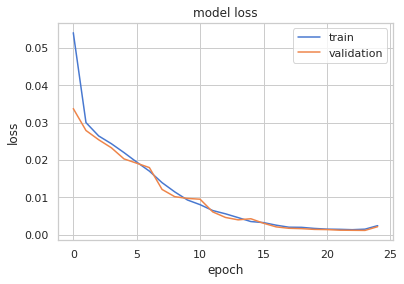

In [36]:
#Plot siamese loss functions
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [37]:
predict = siamese.predict([test_pairs[:, 0], test_pairs[:, 1]])

Here I have created a data frame with the ground truth labels and the predicted distances between the pairs. We have to keep in mind that the smallest the distance is - the higher is the probability the sequences to belong of the same class. So in fact the prediction of 0.9 should correspond to label 0 (opposite classes) and vice versa.

In [38]:
#Create a dataframe with predicted distances and ground truth labels
pr_data = {'predicted':predict.reshape( -1).round(2), 'actual':test_classes.reshape(-1)}
comparisson_df = pd.DataFrame(data = pr_data).astype('float32')

In [39]:
comparisson_df.head()

,predicted,actual
0,0.97,0.0
1,0.99,0.0
2,0.97,0.0
3,0.99,0.0
4,0.75,0.0


In [40]:
#Sorting the predicted distances 
sorted_distances = np.sort(comparisson_df.predicted.unique())

In [41]:
# Getting the train part of the combined_df dataframe
combined_df = pairs_df[TRAIN_SIZE:]
combined_df = combined_df.reset_index()

#Join the columns with predictions
combined_df = combined_df.join(comparisson_df.predicted)

#Drop not needed columns
combined_df = combined_df.drop(columns=['current', 'candidate'])

Here I have constructed a data frame which helped me to find the related data to the predicted variants.

In [42]:
combined_df.head()

,index,current nuc change,current class,paired class,paired nuc change,class,predicted
0,21000,c.4658T>A,pathogenic,non pathogenic,c.4766G>A,[0.0],0.97
1,21001,c.4262A>G,non pathogenic,pathogenic,c.5161C>T,[0.0],0.99
2,21002,c.505C>T,pathogenic,non pathogenic,c.4941C>A,[0.0],0.97
3,21003,c.4675G>A,pathogenic,non pathogenic,c.5024C>T,[0.0],0.99
4,21004,c.172C>G,non pathogenic,pathogenic,c.212G>A,[0.0],0.75


#### The margin
Checking the point from which we can say that a pair similar or not.
Here I looped through the distances and calculated the count of false positive and false negative pairs. Then I found  the distance where false negative and false positive counts were minimal. In this case the distance was 0.58.

In [43]:
counts = {'dist':[],'false positive':[] ,'false negative':[]}
for d in sorted_distances:
    # Find count of false positive and false negative counts for the current distance
    false_positive_count = len(combined_df[(combined_df['predicted'] > d) & (combined_df['class'] == 1)])
    false_negaitive_count = (len(combined_df[(combined_df['predicted'] < d) & (combined_df['class'] == 0)]))
    #Populate a dictionary
    counts['dist'].append(d)
    counts['false positive'].append(false_positive_count)
    counts['false negative'].append(false_negaitive_count)
    print('For distance: {} -> False positive count: {} , False negative count: {} '.format(d,false_positive_count,
                                                                                           false_negaitive_count))

print('False positive median: {} - False negative median: {}'.format(np.median(counts['false positive']),
                                         np.median(counts['false negative'])))

For distance: 0.07999999821186066 -> False positive count: 556 , False negative count: 0 
For distance: 0.09000000357627869 -> False positive count: 397 , False negative count: 0 
For distance: 0.10000000149011612 -> False positive count: 259 , False negative count: 0 
For distance: 0.10999999940395355 -> False positive count: 184 , False negative count: 0 
For distance: 0.11999999731779099 -> False positive count: 146 , False negative count: 0 
For distance: 0.12999999523162842 -> False positive count: 118 , False negative count: 0 
For distance: 0.14000000059604645 -> False positive count: 97 , False negative count: 0 
For distance: 0.15000000596046448 -> False positive count: 77 , False negative count: 0 
For distance: 0.1599999964237213 -> False positive count: 60 , False negative count: 2 
For distance: 0.17000000178813934 -> False positive count: 51 , False negative count: 3 
For distance: 0.18000000715255737 -> False positive count: 45 , False negative count: 3 
For distance: 0.

In [48]:
counts_df = pd.DataFrame(counts)
best_dist = counts_df.loc[(counts_df.dist > 0.57) & (counts_df.dist < 0.59)]
best_dist

,dist,false positive,false negative
37,0.58,5,25


In [49]:
# compute final accuracy on test sets
faults_count = best_dist['false positive'] + best_dist['false negative']
'* Accuracy : %0.2f%%' % (100 - faults_count / (len(test_classes) / 100))

'* Accuracy : 99.60%'

### The results
It is time to get the final results. Pairs between the variants and anomalous sequences were created and passes to the model.

In [50]:
def vec_to_sequence(seq):
    """
    Converting the vector back to a string sequence
    """
    sequence = ''
    for c in range(len(seq)):
        sequence+=seq[c] 
    return sequence

Constructing an array with pairs of anomalous patient data and variants data
and make predictions

In [51]:
for exon_name in patient_exons.keys():
    x = None
    
    # Converting the vector back to a string sequence
    sequence = vec_to_sequence(patient_exons[exon_name])
    # Making the patient exon with the same length as the reference
    anchor = sequence + 'N'* (EXON_MAX_LENGTH-len(sequence))
    # Converting the sequence to one hot vector
    anchor = nucleotide_to_vector(anchor)
    
    # Construct a dataframe with variants of the current exon
    anchor_variants = vec_variants_df[vec_variants_df.location == exon_name].reset_index()
    
    #Construct pairs for the predictions
    for v in range(len(anchor_variants)):
        variant = anchor_variants.loc[v].variant
        if x is None:
            x = [[anchor], [variant]]
        else:
            x[0].append(anchor)
            x[1].append(variant)
    x = np.array(x)
    """
    Make a prediction for the current annomaly
    Get the index of the prediction with the highest probabiliry
    Get the result from the variants dataframe
    """
    index = np.argmin(siamese.predict([x[0], x[1]]), axis=0)
    predicted_variant = anchor_variants.loc[index].values
    #Printing the result for curen exon
    print("Result for {} - mutation type: {}, nucleotide change: {} class: {}"
          .format(exon_name,predicted_variant[0][5],
                  predicted_variant[0][4],
                  predicted_variant[0][3]))

Result for exon_02 - mutation type:  start loss, nucleotide change: c.1A>G class: pathogenic
Result for exon_03 - mutation type:  missense, nucleotide change: c.133A>C class: non pathogenic
Result for exon_04 - mutation type:  missense, nucleotide change: c.154C>A class: non pathogenic
Result for exon_05 - mutation type:  -, nucleotide change: - class: non pathogenic
Result for exon_07 - mutation type:  misssense, nucleotide change: c.469T>C class: non pathogenic
Result for exon_13 - mutation type:  misssense, nucleotide change: c.4402A>C class: non pathogenic
Result for exon_14 - mutation type:  misssense, nucleotide change: c.4520G>C class: non pathogenic


The results were quite accurate. Despite the anomaly in `exon_5` all the other variants were exact.

### Conclusion and Future work
DNA sequencing is a complex, multi-step process that is prone to errors and anomalies. 
The goal of this project was to identify such anomalies (not every anomaly is pathogenic) and classify them according to existing data base.
During this vast research I found that the deep neural networks (particular autoencoders and siamese networks) performed quite well despite a massive data imbalance.

This project was focused only on point mutations. This means that the length of the patient DNA sequence is as long as the referent one. With more time and computational resources, there can be develop more robust project, which can detect and classify the other type of mutation of the DNA (deletions, additions , etc.) 

#### Reference
* [National Library of Medicine](https://www.nlm.nih.gov/)
* [National Human Genome Research Institute](https://www.genome.gov/For-Patients-and-Families/Genetic-Disorders)
* [Human Genomics](https://humgenomics.biomedcentral.com/)
* [Health University of Utah](https://arup.utah.edu/database/BRCA/Variants/BRCA1.php)
* [Breda Genetics](https://bredagenetics.com/start-loss-mutations-in-rare-diseases/)
* [tensorflow.org](https://www.tensorflow.org/tutorials/generative/autoencoder)
* [keras.io](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)
* [yann.lecun.com](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)
* [pyimagesearch](https://www.pyimagesearch.com)
* [Wikipedia](https://wikipedia.com)
* [stackoverflow](https://stackoverflow.com)